# Production, Feed Capacity, Replacement Heifers, Inventory

In [3]:
import pandas as pd
import src

import warnings
warnings.filterwarnings('ignore')

/Users/ericostring/opt/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


#### Production (LB)

In [17]:
production = pd.read_csv('csv/production_incl_calves.csv')
production = src.usda_clean_annual(production, historical=True)

<AxesSubplot:title={'center':'Production (LB)'}, ylabel='Value'>

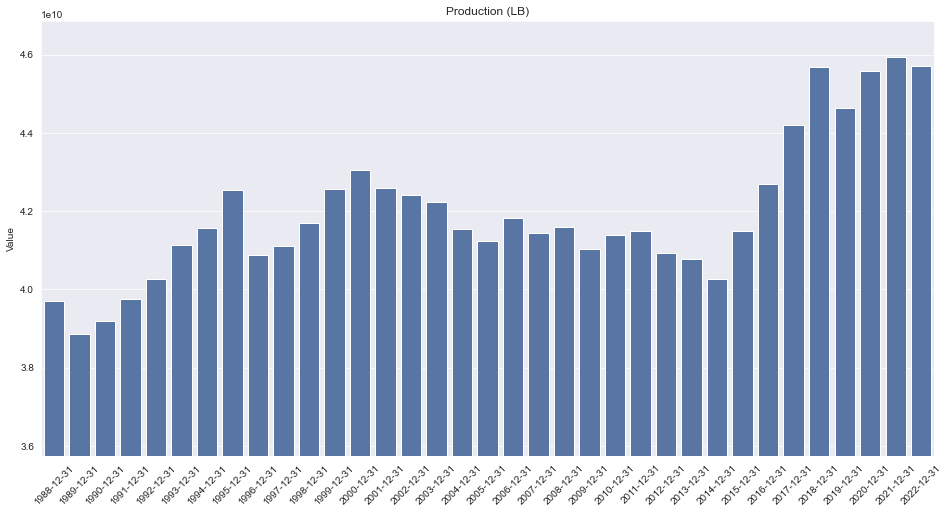

In [22]:
src.barplot(production, title="Production (LB)", ylim=0.1)

In [19]:
price_received_ge_500_national = pd.read_csv('csv/price_received_ge_500_national.csv')
price_received_ge_500_national = src.usda_clean_monthly(price_received_ge_500_national, historical=True)
adj_price_received_ge_500_national = src.adjust_series_cpi(price_received_ge_500_national)

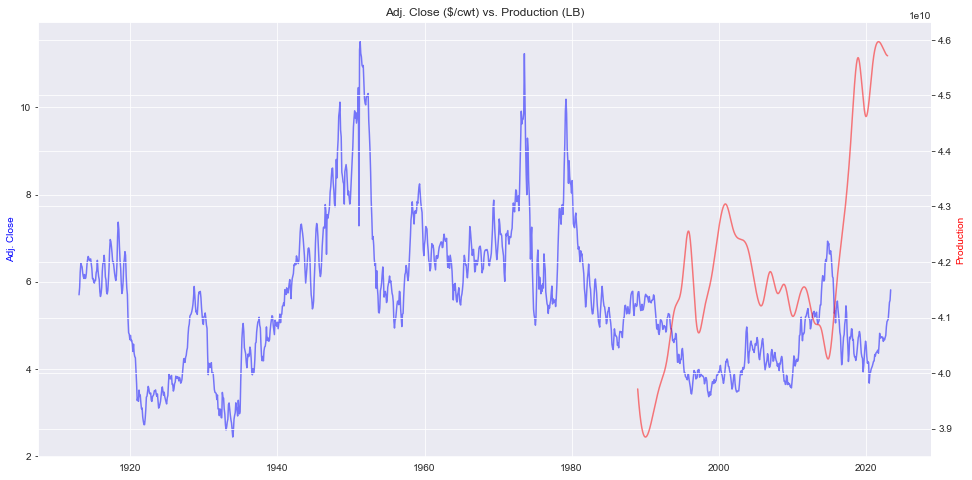

In [20]:
src.lineplot_2_own_axis(
    adj_price_received_ge_500_national,
    src.cubicspline(production),
    'Adj. Close',
    'Production',
    title='Adj. Close ($/cwt) vs. Production (LB)'
    )

1913-12-31    6.137446
1914-12-31    6.381846
1915-12-31    6.070863
1916-12-31    6.097599
1917-12-31    6.496343
                ...   
2019-12-31    4.451161
2020-12-31    4.121944
2021-12-31    4.366933
2022-12-31    4.762768
2023-12-31    5.415698
Freq: A-DEC, Length: 111, dtype: float64

In [75]:
df = pd.DataFrame(
    {'adj_price_received_ge_500_national_pct_change': adj_price_received_ge_500_national.resample('Y').mean().pct_change()*100,
     'production_pct_change': production.resample('Y').last().pct_change()*100
    })

In [76]:
df = df.dropna()

In [77]:
df.head()

,adj_price_received_ge_500_national_pct_change,production_pct_change
1989-12-31,-0.494570,-2.174074
1990-12-31,1.833183,0.904792
1991-12-31,-6.500046,1.432992
1992-12-31,-5.032832,1.230418
1993-12-31,-0.054488,2.202758


In [78]:
import statsmodels.api as sm

model = sm.OLS(df['adj_price_received_ge_500_national_pct_change'], sm.add_constant(df['production_pct_change'])).fit()

print(model.summary())

                                          OLS Regression Results                                         
Dep. Variable:     adj_price_received_ge_500_national_pct_change   R-squared:                       0.081
Model:                                                       OLS   Adj. R-squared:                  0.052
Method:                                            Least Squares   F-statistic:                     2.803
Date:                                           Fri, 01 Sep 2023   Prob (F-statistic):              0.104
Time:                                                   18:29:40   Log-Likelihood:                -120.43
No. Observations:                                             34   AIC:                             244.9
Df Residuals:                                                 32   BIC:                             247.9
Df Model:                                                      1                                         
Covariance Type:                              

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from src.data_wrangling import cubicspline

def scatterplot(*args, resample='Y', method='last', label_point=False, reg=False):

    series = []
    labels = []

    for arg in args:
        
        if isinstance(arg, pd.Series):
            series.append(arg)
        elif isinstance(arg, str):
            labels.append(arg)    

    df = pd.concat(
        [
            getattr(series[0].resample(resample), method)(),
            getattr(series[1].resample(resample), method)()
            ], axis=1).dropna()

    ax = sns.scatterplot(y=df.iloc[:,0], x=df.iloc[:,1], alpha=0.5, hue=df.index, legend=False)

    if label_point:
        for i, label in enumerate(df.index):
            ax.text(df.iloc[i,0], df.iloc[i,1], label.date(), ha='center', va='center')

    if reg:
        # fit an OLS model
        model = sm.OLS(df.iloc[:,0], sm.add_constant(df.iloc[:,1])).fit()

        # plot the regression line
        sns.regplot(x=df.iloc[:,0], y=df.iloc[:,1], scatter=False, color='red', ci=None, line_kws={'label':"y={0:.3f}x+{1:.3f}".format(model.params[1], model.params[0])})
        plt.text(0.05, 0.95, "Slope estimate: {0:.3f}\nIntercept estimate: {1:.3f}\nP-value: {2:.3f}\nR2-value: {3:.3f}".format(model.params[1], model.params[0], model.pvalues[1], model.rsquared), transform=ax.transAxes, fontsize=12, verticalalignment='top')
        plt.legend()

    if len(labels) == 2:
        plt.xlabel(labels[0])
        plt.ylabel(labels[1])

    plt.show()

No handles with labels found to put in legend.


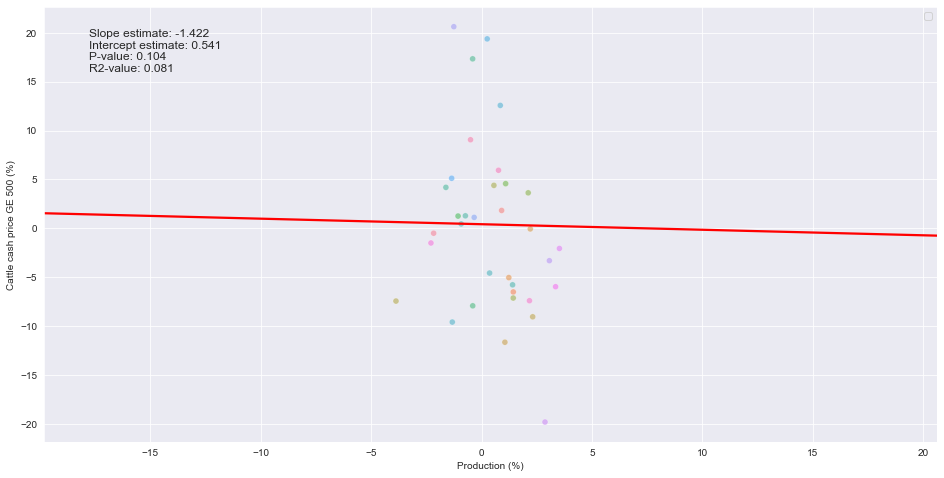

In [74]:
scatterplot(
    df['adj_price_received_ge_500_national_pct_change'],
    df['production_pct_change'],
    'Production (%)',
    'Cattle cash price GE 500 (%)',
    
    reg=True
)

- Alot of variation in cash price not captures by just change in production (yearly basis)
- However production change still plays an indicative role (low p-value)

#### Feed Capacity (Head)

In [19]:
feed_capacity = pd.read_csv('csv/feed_capacity.csv')
feed_capacity = src.usda_clean_annual(feed_capacity, end_of_year=False, historical=True)

<AxesSubplot:title={'center':'Feed Capacity (Head)'}, ylabel='Value'>

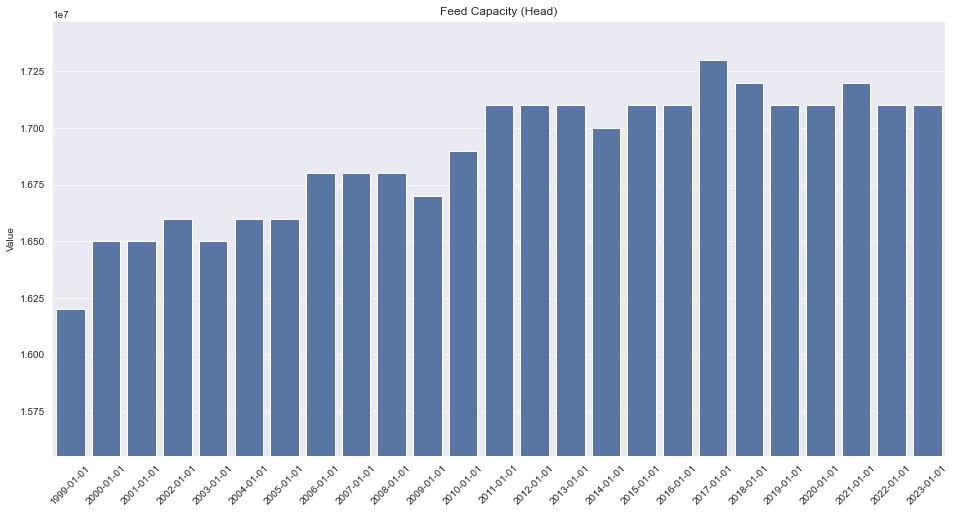

In [20]:
src.barplot(feed_capacity, ylim=0.05, title="Feed Capacity (Head)")

- Interesting trend from 2000-2015. Even though feedlot capacity was increasing, production in LB was decreasing
    - Perhaps feedlots were increasing capacity due to increasing prices, but the real bottleneck was sourcing yearlings from cow-calf operations?
        - If so, would expect the number of yearlings to be decreasing during majority of this period

### Replacement Heifers (Head)

In [22]:
inv_heifers_ge_500_beef_repl = pd.read_csv('csv/inventory_heifers_ge_500_beef_repl.csv')
inv_heifers_ge_500_beef_repl = src.usda_clean_biannual(inv_heifers_ge_500_beef_repl)

<AxesSubplot:title={'center':'CATTLE, HEIFERS, GE 500 LBS, BEEF REPLACEMENT - INVENTORY'}>

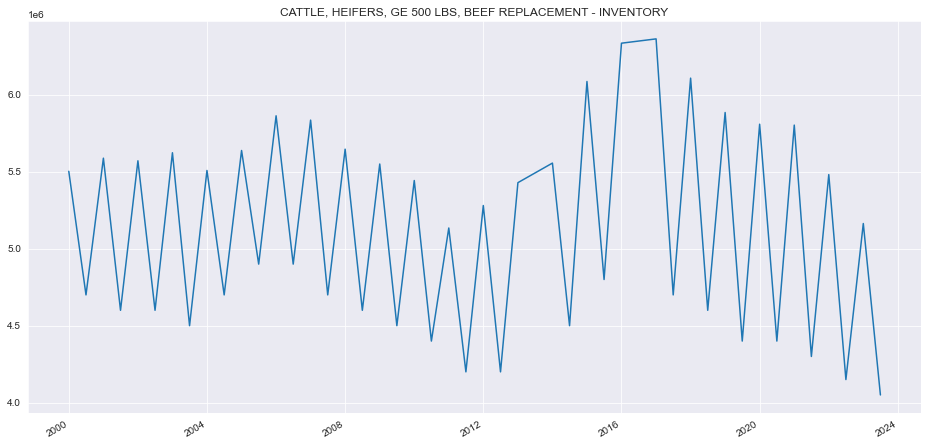

In [10]:
inv_heifers_ge_500_beef_repl.plot(title='CATTLE, HEIFERS, GE 500 LBS, BEEF REPLACEMENT - INVENTORY')

- Biannual data clearly has higher values during first half then second half, however this is not true in two instances?
    - Perhaps to do with reporting methodology? Contact NASS for confirmation

<AxesSubplot:title={'center':'Beef Replacement Heifers (Head)'}>

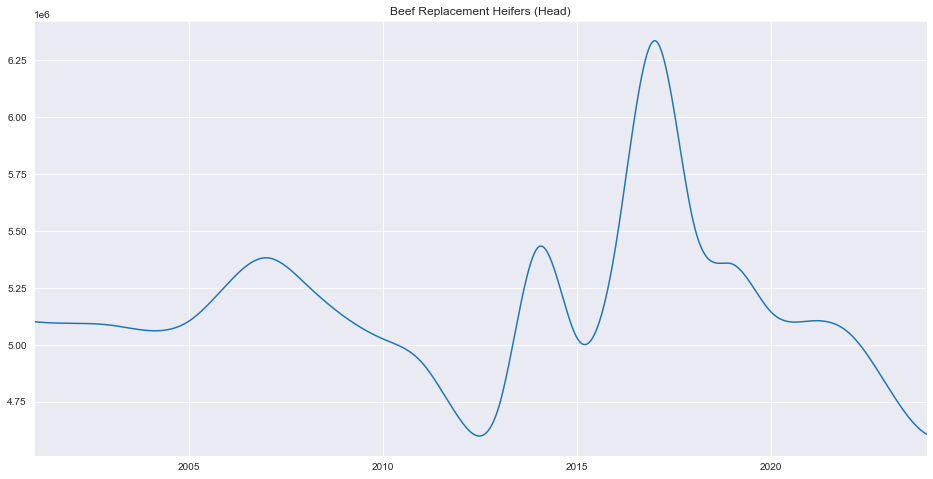

In [11]:
src.cubicspline(inv_heifers_ge_500_beef_repl.resample('Y').mean()).plot(title='Beef Replacement Heifers (Head)')

- Heifers are clearly not being retained

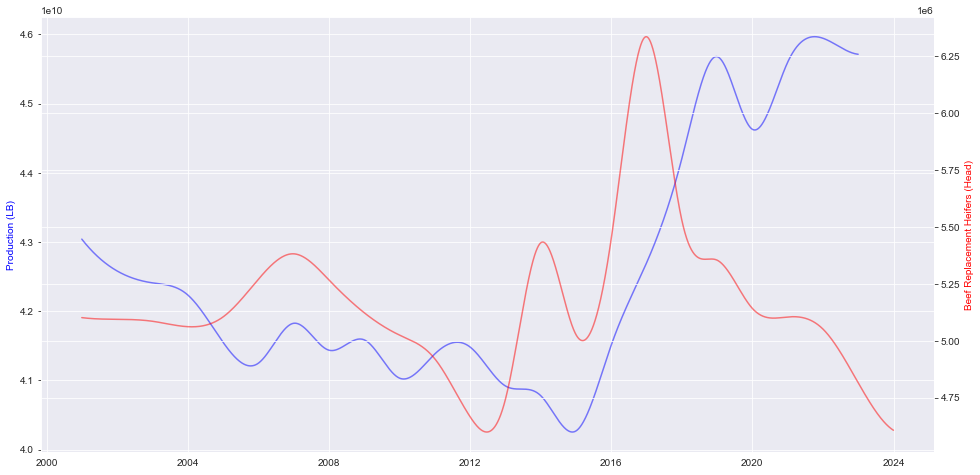

In [12]:
src.lineplot_2_own_axis(
    src.cubicspline(production.resample('Y').mean()),
    src.cubicspline(inv_heifers_ge_500_beef_repl.resample('Y').mean()),
    'Production (LB)',
    'Beef Replacement Heifers (Head)'
)

- Production in LB has been increasing since 2015 bottom, and plateaued at 2019
    - The initial increase in production was due to more heifers, however the sustained high production is probably due to heifers being culled rather than retained for calving
    - This ofcourse is not sustainable
    - If this is the case, we expect inventory in heads to increase from 2015-2019 (as production increases driven by new cattle), then drop (as sustain in productionis driven by cull cows)

#### Inventory (Head)

<AxesSubplot:>

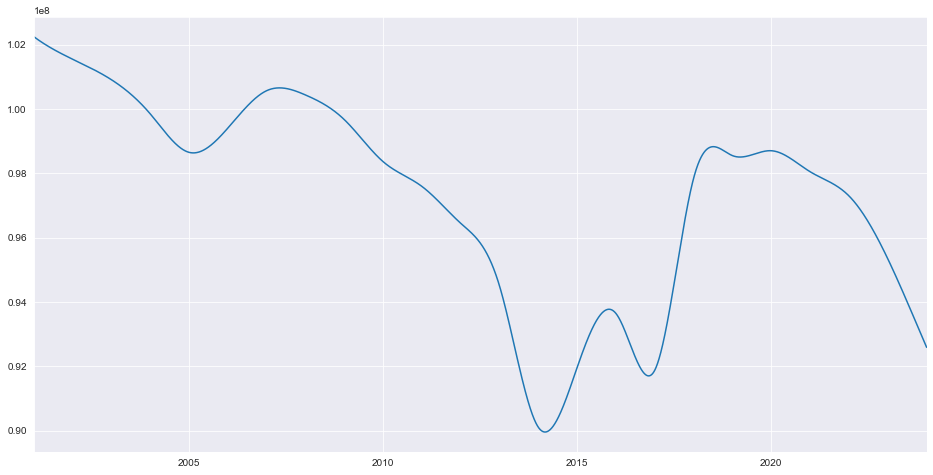

In [13]:
inv_incl_calves = pd.read_csv('csv/inventory_incl_calves.csv')
inv_incl_calves = src.usda_clean_biannual(inv_incl_calves)
src.cubicspline(inv_incl_calves.resample('Y').mean()).plot()

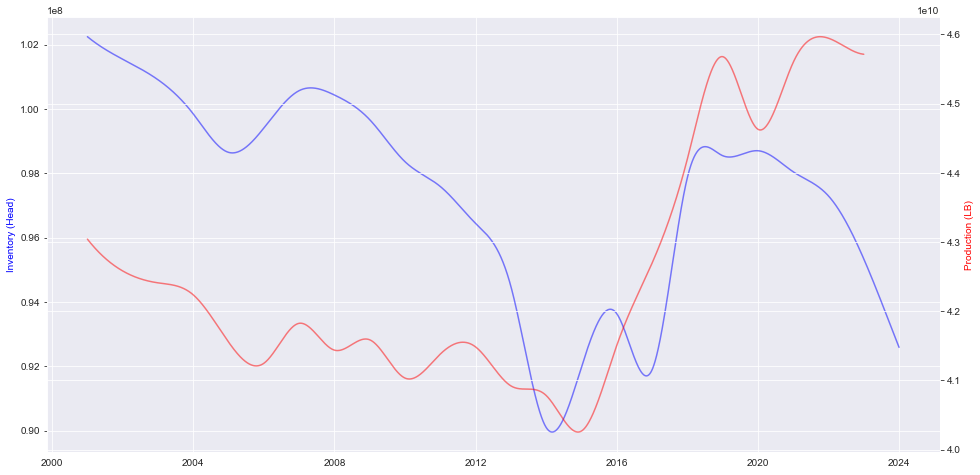

In [24]:
src.lineplot_2_own_axis(
    src.cubicspline(inv_incl_calves.resample('Y').mean()),
    src.cubicspline(production.resample('Y').mean()),
    'Inventory (Head)',
    'Production (LB)',
)

- Check the number of cull cows --> expect this to increase sharply after 2019